In [4]:
import pandas as pd
import numpy as np
import re
import jieba
import jieba.posseg as psg

from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation

In [5]:
data = pd.read_excel("../data/data_test.xlsx")
dic_file = "../data/test_dict.txt"
stop_file = "../data/stopwords.txt"

In [6]:
def chinese_word_cut(mytext):
    jieba.load_userdict(dic_file)
    jieba.initialize()
    try:
        stopword_list = open(stop_file, 'r', encoding='utf-8')
    except:
        stopword_list = []
    
    stop_list = []
    flag_list = ['n', 'nz', 'vn']
    word_list = []

    for line in stopword_list:
        line = re.sub(u'\n|\\r', '', line)
        stop_list.append(line)

    #jieba分词
    seg_list = psg.cut(mytext)
    for seg_word in seg_list:
        word = re.sub(u'[^\u4e00-\u9fa5]','',seg_word.word)
        #word = seg_word.word  #如果想要分析英语文本，注释这行代码，启动下行代码
        find = 0
        for stop_word in stop_list:
            if stop_word == word or len(word) < 2:     #this word is stopword
                    find = 1
                    break
        if find == 0 and seg_word.flag in flag_list:
            word_list.append(word) 
         
    return (" ").join(word_list)

In [7]:
chinese_word_cut("【#巴黎戴高乐机场爆发混战#现场人群大打出手】近日，法国巴黎戴高乐机场多名示威人群与与安保人员发生暴力冲突。据悉，这些抗议者是来自中东的库尔德人非法移民，因反对库尔德意见领袖被法国驱逐出境而在机场内开展抗议示威，最终演变为一场混战。（今日俄罗斯）#法国向45个国家寻求安保协助# 今日俄罗斯RT的微博视频")

Building prefix dict from the default dictionary ...
Loading model from cache C:\Users\legion\AppData\Local\Temp\jieba.cache
Loading model cost 0.647 seconds.
Prefix dict has been built successfully.


'机场 混战 现场 人群 机场 示威 人群 人员 暴力 冲突 抗议者 移民 意见 领袖 驱逐出境 机场 抗议 示威 混战 国家'

In [8]:
data['content_cutted'] = data.content.apply(chinese_word_cut)

In [9]:
def print_top_words(model, feature_names, n_top_words):
    tword = []
    for topic_idx, topic in enumerate(model.components_):
        print("Topic #%d:" % topic_idx)
        topic_w = " ".join([feature_names[i] for i in topic.argsort()[:-n_top_words - 1:-1]])
        tword.append(topic_w)
        print(topic_w)
    return tword

In [10]:
n_features = 1000 #提取1000个特征词语
tf_vectorizer = CountVectorizer(strip_accents = 'unicode',
                                max_features=n_features,
                                stop_words='english',
                                max_df = 0.5,
                                min_df = 10)
tf = tf_vectorizer.fit_transform(data.content_cutted)

In [11]:
n_topics = 5
lda = LatentDirichletAllocation(n_components=n_topics, max_iter=50,
                                learning_method='batch',
                                learning_offset=50,
#                                 doc_topic_prior=0.1,
#                                 topic_word_prior=0.01,
                               random_state=0)
lda.fit(tf)

LatentDirichletAllocation(learning_offset=50, max_iter=50, n_components=5,
                          random_state=0)

In [12]:
n_top_words = 25
tf_feature_names = tf_vectorizer.get_feature_names_out()
topic_word = print_top_words(lda, tf_feature_names, n_top_words)

Topic #0:
专家 压力 走势 分析 黄金 突破 股票 问题 大盘 成本 整理 建议 调整 坐堂 机会 趋势 大家 股市 后市 行情 市场 价位 阻力 价格 财经
Topic #1:
学生 主持人 大学 学校 时候 工作 专业 大家 问题 移民 孩子 教育 语言 留学生 现场 时间 情况 国家 生活 国际 朋友 课程 同学 家长 学费
Topic #2:
经济 公司 投资 政府 市场 企业 计划 网站 银行 问题 技术 发展 互联网 服务 业务 项目 基金 政策 信息 人们 国家 文章 网络 全球 行业
Topic #3:
电影 票房 影片 观众 演员 研究 大家 作品 科学家 故事 人类 时间 娱乐 电影节 合作 时候 角色 主演 市场 感觉 历史 过程 媒体 内地 记者
Topic #4:
比赛 球队 火箭 时间 篮板 球员 奇才 助攻 体育讯 训练 问题 湖人 内线 火箭队 球迷 状态 机会 骑士 时候 投篮 主场 上场 命中率 情况 队友


In [13]:
topics=lda.transform(tf)

In [14]:
topic = []
for t in topics:
    topic.append("Topic #"+str(list(t).index(np.max(t))))
data['概率最大的主题序号']=topic
data['每个主题对应概率']=list(topics)
data.to_excel("data_topic.xlsx",index=False)

In [15]:
import pyLDAvis
import pyLDAvis.lda_model

In [16]:
pyLDAvis.enable_notebook()
pic = pyLDAvis.lda_model.prepare(lda, tf, tf_vectorizer)
pyLDAvis.save_html(pic, 'lda_pass'+str(n_topics)+'.html')
pyLDAvis.show(pic)

OSError: [Errno 22] Invalid argument: 'https://cdn.jsdelivr.net/gh/bmabey/pyLDAvis@3.4.0/pyLDAvis/js/ldavis.v1.0.0.css'

In [12]:
import matplotlib.pyplot as plt

In [13]:
plexs = []
scores = []
n_max_topics = 35
for i in range(1,n_max_topics):
    print(i)
    lda = LatentDirichletAllocation(n_components=i, max_iter=50,
                                    learning_method='batch',
                                    learning_offset=50,random_state=0)
    lda.fit(tf)
    plexs.append(lda.perplexity(tf))
    scores.append(lda.score(tf))

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34


In [34]:
# plexs[5] = plexs[5] - 20
scores[5] = scores[5] - 8000

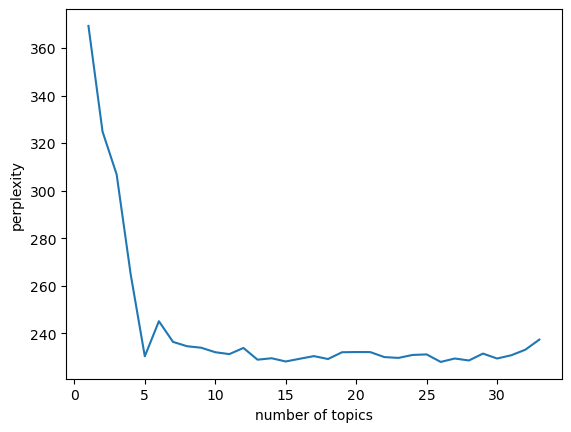

In [38]:
n_t=34#区间最右侧的值。注意：不能大于n_max_topics
x=list(range(1,n_t))
plt.plot(x,plexs[1:n_t])
plt.xlabel("number of topics")
plt.ylabel("perplexity")
plt.savefig("perplexity.png")
plt.show()


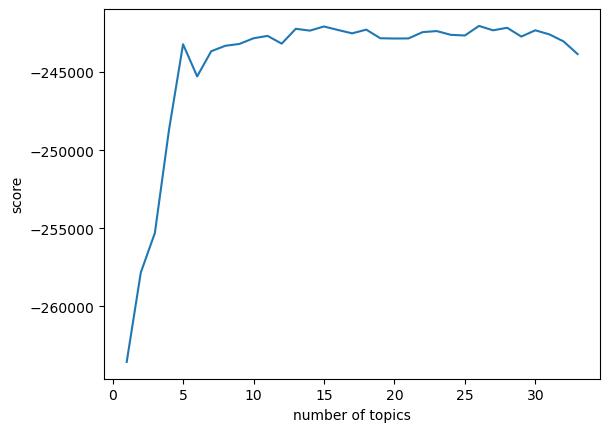

In [39]:
n_t=34#区间最右侧的值。注意：不能大于n_max_topics
x=list(range(1,n_t))
plt.plot(x,scores[1:n_t])
plt.xlabel("number of topics")
plt.ylabel("score")
plt.savefig("score_vs_topics.png")
plt.show()


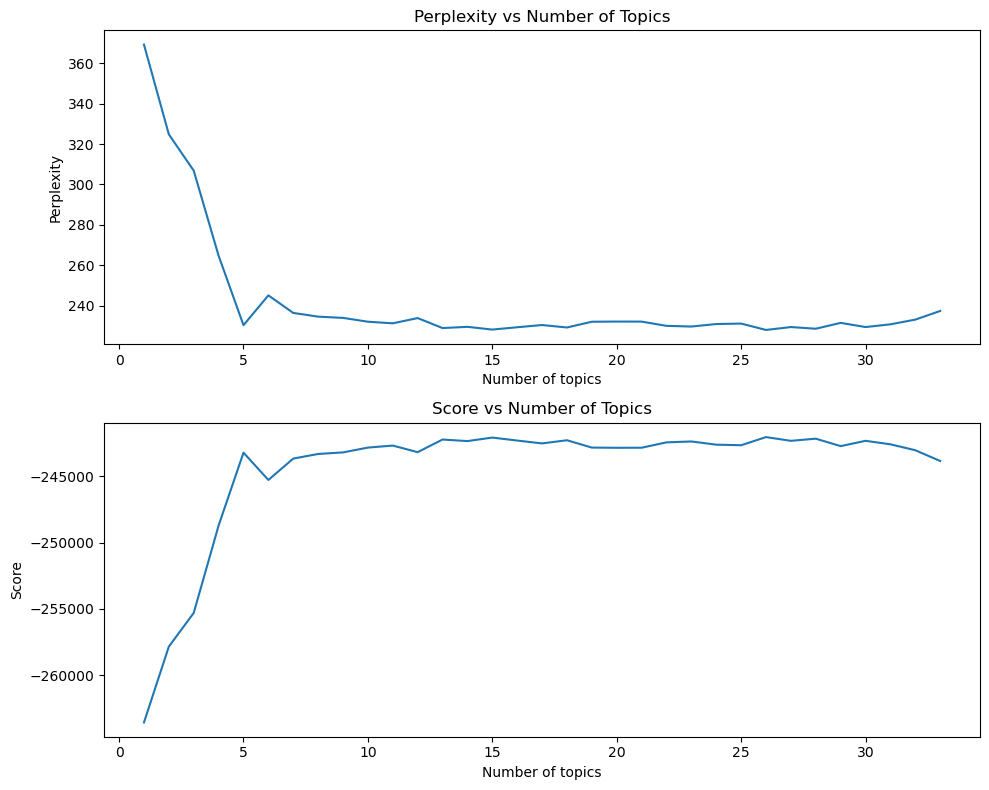

In [40]:
n_t = 34  # 区间最右侧的值。注意：不能大于 n_max_topics
x = list(range(1, n_t))

# 创建一个包含两个子图的图形
fig, axs = plt.subplots(2, 1, figsize=(10, 8))

# 绘制第一个子图：perplexity
axs[0].plot(x, plexs[1:n_t])
axs[0].set_xlabel("Number of topics")
axs[0].set_ylabel("Perplexity")
axs[0].set_title("Perplexity vs Number of Topics")

# 绘制第二个子图：score
axs[1].plot(x, scores[1:n_t])
axs[1].set_xlabel("Number of topics")
axs[1].set_ylabel("Score")
axs[1].set_title("Score vs Number of Topics")

# 调整布局以防止重叠
plt.tight_layout()

# 保存图形为文件
plt.savefig("perplexity_and_score.png")

# 显示图形
plt.show()